In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D,LeakyReLU, MaxPooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

 C:\Users\abhik\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning:Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
 C:\Users\abhik\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning:Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).


In [2]:
#Function to load battery discharge .mat file
def load_data_discharge(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  #print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [3]:
#Function to load battery charge .mat file
def load_data_charge(battery):
  mat = loadmat(battery + '.mat')
  print('Total data in dataset ' + battery + ': ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'charge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_charge = data[0][0]['Current_charge'][0][j]
        voltage_charge = data[0][0]['Voltage_charge'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, 
                        voltage_measured, current_measured,
                        temperature_measured, current_charge,
                        voltage_charge, time])
      counter = counter + 1
  #print(dataset[0])
  return pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_charge', 'voltage_charge', 'time'])

In [4]:
#Load all batteries' discharge and its measured capacity
B0005_discharge, B0005_capacity = load_data_discharge('B0005_LF')
B0006_discharge, B0006_capacity = load_data_discharge('B0006_LF')
B0007_discharge, B0007_capacity = load_data_discharge('B0007_LF')
B0018_discharge, B0018_capacity = load_data_discharge('B0018_LF')
#Load all batteries' charge
B0005_charge = load_data_charge('B0005_LF')
B0006_charge = load_data_charge('B0006_LF')
B0007_charge = load_data_charge('B0007_LF')
B0018_charge = load_data_charge('B0018_LF')

Total data in dataset B0005_LF:  616
Total data in dataset B0006_LF:  616
Total data in dataset B0007_LF:  616
Total data in dataset B0018_LF:  319
Total data in dataset B0005_LF:  616
Total data in dataset B0006_LF:  616
Total data in dataset B0007_LF:  616
Total data in dataset B0018_LF:  319


Text(0.5, 1.0, 'Cell Aging Process')

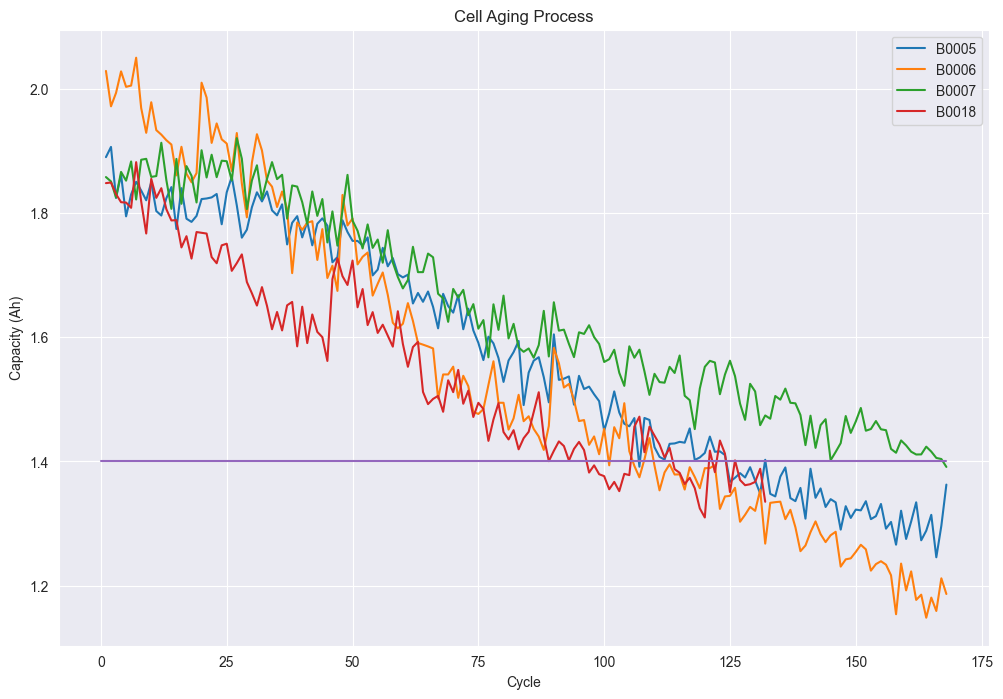

In [5]:
cell_capacity_1 = B0005_capacity
cell_capacity_2 = B0006_capacity
cell_capacity_3 = B0007_capacity
cell_capacity_4 = B0018_capacity
plot_df_1 = cell_capacity_1.loc[(cell_capacity_1['cycle']>=1),['cycle','capacity']]
plot_df_2 = cell_capacity_2.loc[(cell_capacity_2['cycle']>=1),['cycle','capacity']]
plot_df_3 = cell_capacity_3.loc[(cell_capacity_3['cycle']>=1),['cycle','capacity']]
plot_df_4 = cell_capacity_4.loc[(cell_capacity_4['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df_1['cycle'], plot_df_1['capacity'], label='B0005')
plt.plot(plot_df_2['cycle'], plot_df_2['capacity'], label='B0006')
plt.plot(plot_df_3['cycle'], plot_df_3['capacity'], label='B0007')
plt.plot(plot_df_4['cycle'], plot_df_4['capacity'], label='B0018')
#Draw threshold
plt.plot([0.,len(cell_capacity_1)], [1.4, 1.4])
plt.ylabel('Capacity (Ah)')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('Cycle')
plt.legend()
plt.title('Cell Aging Process')

In [6]:
scaler = MinMaxScaler()
feature_discharge = ['capacity', 'voltage_measured', 'current_measured', 
                     'temperature_measured', 'current_load', 
                     'voltage_load', 'time']
feature_charge = ['voltage_measured', 'current_measured', 
                  'temperature_measured', 'current_charge', 
                  'voltage_charge', 'time']

B0005_discharge['cell'] = "B0005"
B0006_discharge['cell'] = "B0006"
B0007_discharge['cell'] = "B0007"
B0018_discharge['cell'] = "B0018"

B0005_charge['cell'] = "B0005"
B0006_charge['cell'] = "B0006"
B0007_charge['cell'] = "B0007"
B0018_charge['cell'] = "B0018"

cell_discharge = pd.concat([B0005_discharge, B0006_discharge, B0007_discharge, B0018_discharge])
cell_charge = pd.concat([B0005_charge, B0006_charge, B0007_charge, B0018_charge])

B0005_SOH = B0005_capacity['capacity']/B0005_capacity['capacity'][0]
B0006_SOH = B0006_capacity['capacity']/B0006_capacity['capacity'][0]
B0007_SOH = B0007_capacity['capacity']/B0007_capacity['capacity'][0]
B0018_SOH = B0018_capacity['capacity']/B0018_capacity['capacity'][0]

X_cell_discharge = scaler.fit_transform(cell_discharge[feature_discharge])
X_cell_discharge = np.insert(X_cell_discharge, 0, cell_discharge['cycle'].to_numpy(), axis=1 )
X_cell_discharge = pd.DataFrame(X_cell_discharge, columns=np.insert(feature_discharge, 0, 'cycle'))
X_cell_discharge['cell'] = cell_discharge.reset_index(drop=True)['cell']

X_cell_charge = scaler.fit_transform(cell_charge[feature_charge])
X_cell_charge = np.insert(X_cell_charge, 0, cell_charge['cycle'].to_numpy(), axis=1 )
X_cell_charge = pd.DataFrame(X_cell_charge, columns=np.insert(feature_charge, 0, 'cycle'))
X_cell_charge['cell'] = cell_charge.reset_index(drop=True)['cell']

X_B0005_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0005']
X_B0006_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0006']
X_B0007_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0007']
X_B0018_discharge = X_cell_discharge.loc[X_cell_discharge['cell'] == 'B0018']

X_B0005_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0005']
X_B0006_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0006']
X_B0007_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0007']
X_B0018_charge = X_cell_charge.loc[X_cell_charge['cell'] == 'B0018']


In [7]:
#Extract nsample data of battery's voltage, current and temperature for a specific cycle
def extract_cycle_VIT(batt, nsample, ncyl, features):
    nfeatures = len(features)
    out = batt.loc[batt['cycle']==ncyl, features]
    out = out.head(nsample)#out.sample(n = nsample)
    out = out.melt(ignore_index=True)
    out = out['value'].values.reshape(1, nfeatures*nsample, 1)
    return out

#Extract nsample data of battery's voltage, current and temperature for all cycles
def extract_VIT(batt, nsample, features):
    data = []
    temp_cyc = batt['cycle'].drop_duplicates(keep='first')
    for i in range(1, len(temp_cyc)):
        temp = extract_cycle_VIT(batt, nsample, i, features)
        data.append(temp)
    arr = np.array(data)
    return arr

#Set up training dataset of 3 batteries
def set_x_training_dataset(batt1, batt2, batt3):
    xTrain = np.append(batt1[0:len(batt1)-1], batt2[0:len(batt2)-1], axis=0)
    xTrain = np.append(xTrain, batt3[0:len(batt3)-1], axis=0)
    return xTrain

#Set up training label of 3 batteries
def set_y_training_dataset(batt1, batt2, batt3):
    yTrain = np.append(batt1, batt2, axis=0)
    yTrain = np.append(yTrain, batt3, axis=0)
    return yTrain

#Set up test dataset of 3 batteries
def set_x_test_dataset(batt):
    xTest = np.array(batt[0:len(batt)-1])
    return xTest

#Set up test label of 3 batteries
def set_y_test_dataset(batt):
    xTest = np.array(batt)
    return xTest


In [8]:
#Set sample to 10
nsample = 10

#Set required features to be loaded
features = ['voltage_measured', 
            'current_measured', 
            'temperature_measured', 
            'current_charge', 
            'voltage_charge', 
            'cycle']

nfeatures = len(features)

#Load VIT features of all batteries dataset
dt_B0005_VIT = extract_VIT(X_B0005_charge, nsample, features)
dt_B0006_VIT = extract_VIT(X_B0006_charge, nsample, features)
dt_B0007_VIT = extract_VIT(X_B0007_charge, nsample, features)
dt_B0018_VIT = extract_VIT(X_B0018_charge, nsample, features)

#Set up the training and test dataset
xTrain = set_x_training_dataset(dt_B0005_VIT, dt_B0006_VIT, dt_B0007_VIT)

#Set up the training and test label
yTrain = set_y_training_dataset(B0005_SOH, B0006_SOH, B0007_SOH)
X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

In [9]:
# Building the CNN model
input_shape = xTrain[1].shape
model = Sequential()
model.add(Conv2D(30, kernel_size=(1, 2), strides=(1, 1), input_shape=input_shape))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(1,2))
model.add(Conv2D(15, kernel_size=(1, 2),strides=(1, 1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(1,2))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
print(model.summary())

 C:\Users\abhik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 C:\Users\abhik\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:Argument `alpha` is deprecated. Use `negative_slope` instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1, 59, 30)           │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1, 59, 30)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 30, 30)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 29, 15)           │             915 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 1, 29, 15)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 15, 15)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 225)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             226 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231 (4.81 KB)

 Trainable params: 1,231 (4.81 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [11]:
history = model.fit(X_train,y_train,epochs=500, batch_size=50, verbose=2, validation_split = 0.2)

Epoch 1/500
7/7 - 1s - 141ms/step - loss: 2.5806 - val_loss: 0.8633
Epoch 2/500
7/7 - 0s - 17ms/step - loss: 0.8530 - val_loss: 0.6306
Epoch 3/500
7/7 - 0s - 16ms/step - loss: 0.5654 - val_loss: 0.6028
Epoch 4/500
7/7 - 0s - 16ms/step - loss: 0.4030 - val_loss: 0.4288
Epoch 5/500
7/7 - 0s - 17ms/step - loss: 0.3263 - val_loss: 0.3904
Epoch 6/500
7/7 - 0s - 17ms/step - loss: 0.2739 - val_loss: 0.2782
Epoch 7/500
7/7 - 0s - 16ms/step - loss: 0.2384 - val_loss: 0.2621
Epoch 8/500
7/7 - 0s - 15ms/step - loss: 0.2113 - val_loss: 0.2037
Epoch 9/500
7/7 - 0s - 16ms/step - loss: 0.1773 - val_loss: 0.1793
Epoch 10/500
7/7 - 0s - 16ms/step - loss: 0.1441 - val_loss: 0.1408
Epoch 11/500
7/7 - 0s - 18ms/step - loss: 0.1209 - val_loss: 0.1150
Epoch 12/500
7/7 - 0s - 16ms/step - loss: 0.0952 - val_loss: 0.0857
Epoch 13/500
7/7 - 0s - 15ms/step - loss: 0.0710 - val_loss: 0.0622
Epoch 14/500
7/7 - 0s - 16ms/step - loss: 0.0509 - val_loss: 0.0436
Epoch 15/500
7/7 - 0s - 16ms/step - loss: 0.0328 - val_l

Epoch 122/500
7/7 - 0s - 14ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 123/500
7/7 - 0s - 14ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 124/500
7/7 - 0s - 14ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 125/500
7/7 - 0s - 15ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 126/500
7/7 - 0s - 16ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 127/500
7/7 - 0s - 16ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 128/500
7/7 - 0s - 15ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 129/500
7/7 - 0s - 15ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 130/500
7/7 - 0s - 15ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 131/500
7/7 - 0s - 15ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 132/500
7/7 - 0s - 15ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 133/500
7/7 - 0s - 15ms/step - loss: 0.0030 - val_loss: 0.0033
Epoch 134/500
7/7 - 0s - 15ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 135/500
7/7 - 0s - 16ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 136/500
7/7 - 0s - 15ms/step

Epoch 241/500
7/7 - 0s - 13ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 242/500
7/7 - 0s - 14ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 243/500
7/7 - 0s - 14ms/step - loss: 0.0023 - val_loss: 0.0039
Epoch 244/500
7/7 - 0s - 14ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 245/500
7/7 - 0s - 14ms/step - loss: 0.0031 - val_loss: 0.0045
Epoch 246/500
7/7 - 0s - 14ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 247/500
7/7 - 0s - 15ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 248/500
7/7 - 0s - 14ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 249/500
7/7 - 0s - 14ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 250/500
7/7 - 0s - 13ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 251/500
7/7 - 0s - 14ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 252/500
7/7 - 0s - 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 253/500
7/7 - 0s - 13ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 254/500
7/7 - 0s - 13ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 255/500
7/7 - 0s - 13ms/step

Epoch 360/500
7/7 - 0s - 13ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 361/500
7/7 - 0s - 12ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 362/500
7/7 - 0s - 13ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 363/500
7/7 - 0s - 13ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 364/500
7/7 - 0s - 13ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 365/500
7/7 - 0s - 11ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 366/500
7/7 - 0s - 11ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 367/500
7/7 - 0s - 11ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 368/500
7/7 - 0s - 12ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 369/500
7/7 - 0s - 11ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 370/500
7/7 - 0s - 13ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 371/500
7/7 - 0s - 14ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 372/500
7/7 - 0s - 14ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 373/500
7/7 - 0s - 14ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch 374/500
7/7 - 0s - 14ms/step

Epoch 479/500
7/7 - 0s - 13ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 480/500
7/7 - 0s - 13ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 481/500
7/7 - 0s - 15ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 482/500
7/7 - 0s - 13ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 483/500
7/7 - 0s - 13ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 484/500
7/7 - 0s - 13ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 485/500
7/7 - 0s - 14ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 486/500
7/7 - 0s - 14ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 487/500
7/7 - 0s - 14ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 488/500
7/7 - 0s - 15ms/step - loss: 0.0025 - val_loss: 0.0072
Epoch 489/500
7/7 - 0s - 17ms/step - loss: 0.0066 - val_loss: 0.0093
Epoch 490/500
7/7 - 0s - 17ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 491/500
7/7 - 0s - 15ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 492/500
7/7 - 0s - 13ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 493/500
7/7 - 0s - 13ms/step

In [12]:
y_pred = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test,y_pred)
print('Mean Absolute Error:', test_loss)
print('Root Mean Square Error:', rmse)
print('R-squared:', r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080
Mean Absolute Error: 0.007723564747720957
Root Mean Square Error: 0.08788381295011986
R-squared: 0.3834001740832168


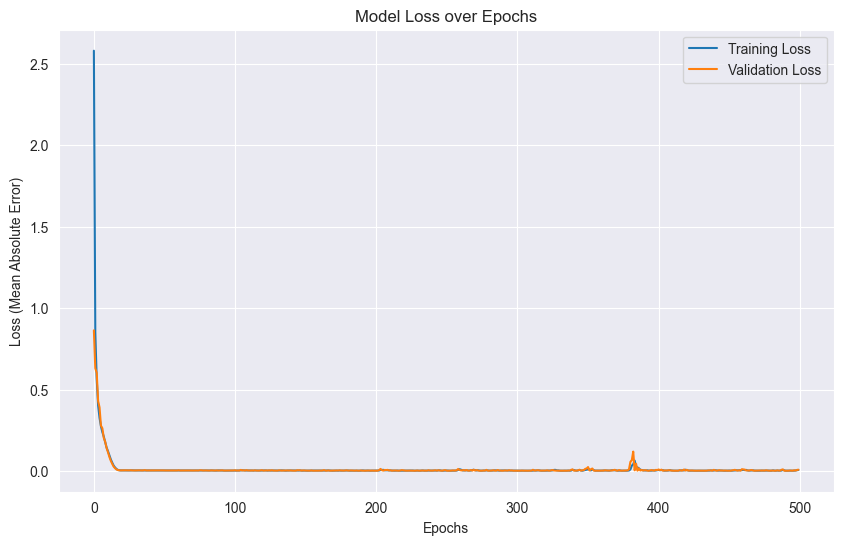

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
#Start of Gaussian Process

In [20]:
dt_B0005_cycle = dt_B0005_VIT[:, :, 5].reshape(-1, 1)  # Reshape to (n_samples, 1)
dt_B0005_voltage_measured = dt_B0005_VIT[:, :, 0].reshape(-1, 1) 
dt_B0006_cycle = dt_B0006_VIT[:, :, 5].reshape(-1, 1)  # Reshape to (n_samples, 1)
dt_B0006_voltage_measured = dt_B0006_VIT[:, :, 0].reshape(-1, 1) 
dt_B0007_cycle = dt_B0007_VIT[:, :, 5].reshape(-1, 1)  # Reshape to (n_samples, 1)
dt_B0007_voltage_measured = dt_B0007_VIT[:, :, 0].reshape(-1, 1) 

kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)+GPy.kern.PeriodicExponential(input_dim=1, variance=0.01)

# Create Gaussian Process Regression model
B0005_model_voltage_measured = GPy.models.GPRegression(dt_B0005_cycle, dt_B0005_voltage_measured, kernel)
B0005_model_voltage_measured.optimize(messages=True)
B0005_voltage_measured_prediction, variance= B0005_model_voltage_measured.predict(dt_B0005_cycle)

B0006_model_voltage_measured = GPy.models.GPRegression(dt_B0006_cycle, dt_B0006_voltage_measured, kernel)
B0006_model_voltage_measured.optimize(messages=True)
B0006_voltage_measured_prediction, _= B0006_model_voltage_measured.predict(dt_B0006_cycle)

B0007_model_voltage_measured = GPy.models.GPRegression(dt_B0007_cycle, dt_B0007_voltage_measured, kernel)
B0007_model_voltage_measured.optimize(messages=True)
B0007_voltage_measured_prediction, _= B0007_model_voltage_measured.predict(dt_B0007_cycle)


In [21]:
dt_B0005_current_measured = dt_B0005_VIT[:, :, 1].reshape(-1, 1) 
dt_B0006_current_measured = dt_B0006_VIT[:, :, 1].reshape(-1, 1) 
dt_B0007_current_measured = dt_B0007_VIT[:, :, 1].reshape(-1, 1) 

B0005_model_current_measured = GPy.models.GPRegression(dt_B0005_cycle, dt_B0005_current_measured, kernel)
B0005_model_current_measured.optimize(messages=True)
B0005_current_measured_prediction, _= B0005_model_current_measured.predict(dt_B0005_cycle)

B0006_model_current_measured = GPy.models.GPRegression(dt_B0006_cycle, dt_B0006_current_measured, kernel)
B0006_model_current_measured.optimize(messages=True)
B0006_current_measured_prediction, _= B0006_model_current_measured.predict(dt_B0006_cycle)

B0007_model_current_measured = GPy.models.GPRegression(dt_B0007_cycle, dt_B0007_current_measured, kernel)
B0007_model_current_measured.optimize(messages=True)
B0007_current_measured_prediction, _= B0007_model_current_measured.predict(dt_B0007_cycle)

In [22]:
dt_B0005_temperature_measured = dt_B0005_VIT[:, :, 2].reshape(-1, 1) 
dt_B0006_temperature_measured = dt_B0006_VIT[:, :, 2].reshape(-1, 1) 
dt_B0007_temperature_measured = dt_B0007_VIT[:, :, 2].reshape(-1, 1) 

B0005_model_temperature_measured = GPy.models.GPRegression(dt_B0005_cycle, dt_B0005_temperature_measured, kernel)
B0005_model_temperature_measured.optimize(messages=True)
B0005_temperature_measured_prediction, _= B0005_model_temperature_measured.predict(dt_B0005_cycle)

B0006_model_temperature_measured = GPy.models.GPRegression(dt_B0006_cycle, dt_B0006_temperature_measured, kernel)
B0006_model_temperature_measured.optimize(messages=True)
B0006_temperature_measured_prediction, _= B0006_model_temperature_measured.predict(dt_B0006_cycle)

B0007_model_temperature_measured = GPy.models.GPRegression(dt_B0007_cycle, dt_B0007_temperature_measured, kernel)
B0007_model_temperature_measured.optimize(messages=True)
B0007_temperature_measured_prediction, _= B0007_model_temperature_measured.predict(dt_B0007_cycle)

In [23]:
dt_B0005_current_charge = dt_B0005_VIT[:, :, 3].reshape(-1, 1) 
dt_B0006_current_charge = dt_B0006_VIT[:, :, 3].reshape(-1, 1) 
dt_B0007_current_charge = dt_B0007_VIT[:, :, 3].reshape(-1, 1) 

B0005_model_current_charge = GPy.models.GPRegression(dt_B0005_cycle, dt_B0005_current_charge, kernel)
B0005_model_current_charge.optimize(messages=True)
B0005_current_charge_prediction, _= B0005_model_current_charge.predict(dt_B0005_cycle)

B0006_model_current_charge = GPy.models.GPRegression(dt_B0006_cycle, dt_B0006_current_charge, kernel)
B0006_model_current_charge.optimize(messages=True)
B0006_current_charge_prediction, _= B0006_model_current_charge.predict(dt_B0006_cycle)

B0007_model_current_charge = GPy.models.GPRegression(dt_B0007_cycle, dt_B0007_current_charge, kernel)
B0007_model_current_charge.optimize(messages=True)
B0007_current_charge_prediction, _= B0007_model_current_charge.predict(dt_B0007_cycle)

In [24]:
dt_B0005_voltage_charge = dt_B0005_VIT[:, :, 4].reshape(-1, 1) 
dt_B0006_voltage_charge = dt_B0006_VIT[:, :, 4].reshape(-1, 1) 
dt_B0007_voltage_charge = dt_B0007_VIT[:, :, 4].reshape(-1, 1) 

B0005_model_voltage_charge = GPy.models.GPRegression(dt_B0005_cycle, dt_B0005_voltage_charge, kernel)
B0005_model_voltage_charge.optimize(messages=True)
B0005_voltage_charge_prediction, _= B0005_model_voltage_charge.predict(dt_B0005_cycle)

B0006_model_voltage_charge = GPy.models.GPRegression(dt_B0006_cycle, dt_B0006_voltage_charge, kernel)
B0006_model_voltage_charge.optimize(messages=True)
B0006_voltage_charge_prediction, _= B0006_model_voltage_charge.predict(dt_B0006_cycle)

B0007_model_voltage_charge = GPy.models.GPRegression(dt_B0007_cycle, dt_B0007_voltage_charge, kernel)
B0007_model_voltage_charge.optimize(messages=True)
B0007_voltage_charge_prediction, _= B0007_model_voltage_charge.predict(dt_B0007_cycle)

In [25]:
B0005_voltage_measured_prediction = np.expand_dims(B0005_voltage_measured_prediction, axis = 2)
B0005_current_measured_prediction = np.expand_dims(B0005_current_measured_prediction, axis = 2)
B0005_temperature_measured_prediction = np.expand_dims(B0005_temperature_measured_prediction, axis = 2)
B0005_current_charge_prediction = np.expand_dims(B0005_current_charge_prediction, axis = 2)
B0005_voltage_charge_prediction = np.expand_dims(B0005_voltage_charge_prediction, axis = 2)
dt_B0005_cycle = np.expand_dims(dt_B0005_cycle, axis = 2)

B0005_VIT_denoised = np.stack((B0005_voltage_measured_prediction,B0005_current_measured_prediction, B0005_temperature_measured_prediction,
                     B0005_current_charge_prediction,  B0005_voltage_charge_prediction, dt_B0005_cycle), axis=2)

B0006_voltage_measured_prediction = np.expand_dims(B0006_voltage_measured_prediction, axis = 2)
B0006_current_measured_prediction = np.expand_dims(B0006_current_measured_prediction, axis = 2)
B0006_temperature_measured_prediction = np.expand_dims(B0006_temperature_measured_prediction, axis = 2)
B0006_current_charge_prediction = np.expand_dims(B0006_current_charge_prediction, axis = 2)
B0006_voltage_charge_prediction = np.expand_dims(B0006_voltage_charge_prediction, axis = 2)
dt_B0006_cycle = np.expand_dims(dt_B0006_cycle, axis = 2)

B0006_VIT_denoised = np.stack((B0006_voltage_measured_prediction,B0006_current_measured_prediction, B0006_temperature_measured_prediction,
                     B0006_current_charge_prediction,  B0006_voltage_charge_prediction, dt_B0006_cycle), axis=2)

B0007_voltage_measured_prediction = np.expand_dims(B0007_voltage_measured_prediction, axis = 2)
B0007_current_measured_prediction = np.expand_dims(B0007_current_measured_prediction, axis = 2)
B0007_temperature_measured_prediction = np.expand_dims(B0007_temperature_measured_prediction, axis = 2)
B0007_current_charge_prediction = np.expand_dims(B0007_current_charge_prediction, axis = 2)
B0007_voltage_charge_prediction = np.expand_dims(B0007_voltage_charge_prediction, axis = 2)
dt_B0007_cycle = np.expand_dims(dt_B0007_cycle, axis = 2)

B0007_VIT_denoised = np.stack((B0007_voltage_measured_prediction,B0007_current_measured_prediction, B0007_temperature_measured_prediction,
                     B0007_current_charge_prediction,  B0007_voltage_charge_prediction, dt_B0007_cycle), axis=2)

In [26]:
#Set up the training and test dataset
xTrain = set_x_training_dataset(B0005_VIT_denoised, B0006_VIT_denoised, B0007_VIT_denoised)

#Set up the training and test label
yTrain = set_y_training_dataset(B0005_SOH, B0006_SOH, B0007_SOH)
X_train, X_test, y_train, y_test = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

In [27]:
# Building the CNN model
input_shape_denoised = xTrain[1].shape
model_denoised = Sequential()
model_denoised.add(Conv2D(30, kernel_size=(1, 2), strides=(1, 1), input_shape=input_shape_denoised))
model_denoised.add(LeakyReLU(alpha=0.1))
model_denoised.add(MaxPooling2D(1,2))
model_denoised.add(Conv2D(15, kernel_size=(1, 2),strides=(1, 1)))
model_denoised.add(LeakyReLU(alpha=0.1))
model_denoised.add(MaxPooling2D(1,2))
model_denoised.add(Flatten())
model_denoised.add(Dense(1, activation='linear'))
print(model_denoised.summary())

 C:\Users\abhik\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
 C:\Users\abhik\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning:Argument `alpha` is deprecated. Use `negative_slope` instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 1, 5, 30)            │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1, 5, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 3, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 2, 15)            │             915 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 1, 2, 15)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 15)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,021 (3.99 KB)

 Trainable params: 1,021 (3.99 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
model_denoised.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

In [29]:
history_denoised = model_denoised.fit(X_train,y_train,epochs=500, batch_size=50, verbose=2, validation_split = 0.2)

Epoch 1/500
7/7 - 1s - 122ms/step - loss: 0.7218 - val_loss: 0.6645
Epoch 2/500
7/7 - 0s - 14ms/step - loss: 0.6257 - val_loss: 0.5754
Epoch 3/500
7/7 - 0s - 15ms/step - loss: 0.5369 - val_loss: 0.4868
Epoch 4/500
7/7 - 0s - 16ms/step - loss: 0.4438 - val_loss: 0.3832
Epoch 5/500
7/7 - 0s - 14ms/step - loss: 0.3379 - val_loss: 0.2764
Epoch 6/500
7/7 - 0s - 14ms/step - loss: 0.2296 - val_loss: 0.1716
Epoch 7/500
7/7 - 0s - 14ms/step - loss: 0.1334 - val_loss: 0.0878
Epoch 8/500
7/7 - 0s - 13ms/step - loss: 0.0620 - val_loss: 0.0369
Epoch 9/500
7/7 - 0s - 15ms/step - loss: 0.0248 - val_loss: 0.0191
Epoch 10/500
7/7 - 0s - 15ms/step - loss: 0.0159 - val_loss: 0.0198
Epoch 11/500
7/7 - 0s - 14ms/step - loss: 0.0190 - val_loss: 0.0215
Epoch 12/500
7/7 - 0s - 15ms/step - loss: 0.0193 - val_loss: 0.0198
Epoch 13/500
7/7 - 0s - 15ms/step - loss: 0.0173 - val_loss: 0.0184
Epoch 14/500
7/7 - 0s - 15ms/step - loss: 0.0162 - val_loss: 0.0183
Epoch 15/500
7/7 - 0s - 14ms/step - loss: 0.0160 - val_l

Epoch 122/500
7/7 - 0s - 14ms/step - loss: 0.0121 - val_loss: 0.0134
Epoch 123/500
7/7 - 0s - 15ms/step - loss: 0.0121 - val_loss: 0.0133
Epoch 124/500
7/7 - 0s - 15ms/step - loss: 0.0120 - val_loss: 0.0132
Epoch 125/500
7/7 - 0s - 14ms/step - loss: 0.0120 - val_loss: 0.0131
Epoch 126/500
7/7 - 0s - 14ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 127/500
7/7 - 0s - 14ms/step - loss: 0.0118 - val_loss: 0.0130
Epoch 128/500
7/7 - 0s - 16ms/step - loss: 0.0116 - val_loss: 0.0130
Epoch 129/500
7/7 - 0s - 17ms/step - loss: 0.0116 - val_loss: 0.0128
Epoch 130/500
7/7 - 0s - 14ms/step - loss: 0.0115 - val_loss: 0.0127
Epoch 131/500
7/7 - 0s - 13ms/step - loss: 0.0115 - val_loss: 0.0126
Epoch 132/500
7/7 - 0s - 16ms/step - loss: 0.0115 - val_loss: 0.0125
Epoch 133/500
7/7 - 0s - 14ms/step - loss: 0.0113 - val_loss: 0.0125
Epoch 134/500
7/7 - 0s - 15ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 135/500
7/7 - 0s - 14ms/step - loss: 0.0111 - val_loss: 0.0122
Epoch 136/500
7/7 - 0s - 16ms/step

Epoch 241/500
7/7 - 0s - 13ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 242/500
7/7 - 0s - 13ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 243/500
7/7 - 0s - 12ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 244/500
7/7 - 0s - 12ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 245/500
7/7 - 0s - 12ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 246/500
7/7 - 0s - 14ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 247/500
7/7 - 0s - 14ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 248/500
7/7 - 0s - 13ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 249/500
7/7 - 0s - 13ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 250/500
7/7 - 0s - 13ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 251/500
7/7 - 0s - 13ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 252/500
7/7 - 0s - 13ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 253/500
7/7 - 0s - 13ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 254/500
7/7 - 0s - 13ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 255/500
7/7 - 0s - 12ms/step

Epoch 360/500
7/7 - 0s - 13ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 361/500
7/7 - 0s - 13ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 362/500
7/7 - 0s - 13ms/step - loss: 0.0045 - val_loss: 0.0055
Epoch 363/500
7/7 - 0s - 12ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 364/500
7/7 - 0s - 12ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 365/500
7/7 - 0s - 13ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 366/500
7/7 - 0s - 13ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 367/500
7/7 - 0s - 12ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 368/500
7/7 - 0s - 13ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 369/500
7/7 - 0s - 13ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 370/500
7/7 - 0s - 13ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 371/500
7/7 - 0s - 13ms/step - loss: 0.0045 - val_loss: 0.0054
Epoch 372/500
7/7 - 0s - 13ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 373/500
7/7 - 0s - 13ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 374/500
7/7 - 0s - 13ms/step

Epoch 479/500
7/7 - 0s - 13ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 480/500
7/7 - 0s - 14ms/step - loss: 0.0040 - val_loss: 0.0049
Epoch 481/500
7/7 - 0s - 14ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 482/500
7/7 - 0s - 15ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 483/500
7/7 - 0s - 16ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 484/500
7/7 - 0s - 14ms/step - loss: 0.0041 - val_loss: 0.0049
Epoch 485/500
7/7 - 0s - 16ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 486/500
7/7 - 0s - 17ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 487/500
7/7 - 0s - 18ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 488/500
7/7 - 0s - 14ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 489/500
7/7 - 0s - 15ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 490/500
7/7 - 0s - 14ms/step - loss: 0.0042 - val_loss: 0.0050
Epoch 491/500
7/7 - 0s - 15ms/step - loss: 0.0041 - val_loss: 0.0046
Epoch 492/500
7/7 - 0s - 15ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 493/500
7/7 - 0s - 15ms/step

In [30]:
denoised_y_pred = model_denoised.predict(X_test)
denoised_test_loss = model_denoised.evaluate(X_test, y_test)
denoised_rmse = np.sqrt(mean_squared_error(y_test, denoised_y_pred))
denoised_r2 = r2_score(y_test,denoised_y_pred)
print('Mean Absolute Error:', denoised_test_loss)
print('Root Mean Square Error:', denoised_rmse)
print('R-squared:', denoised_r2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048
Mean Absolute Error: 0.005282297730445862
Root Mean Square Error: 0.07267941368678323
R-squared: 0.5782952955631209


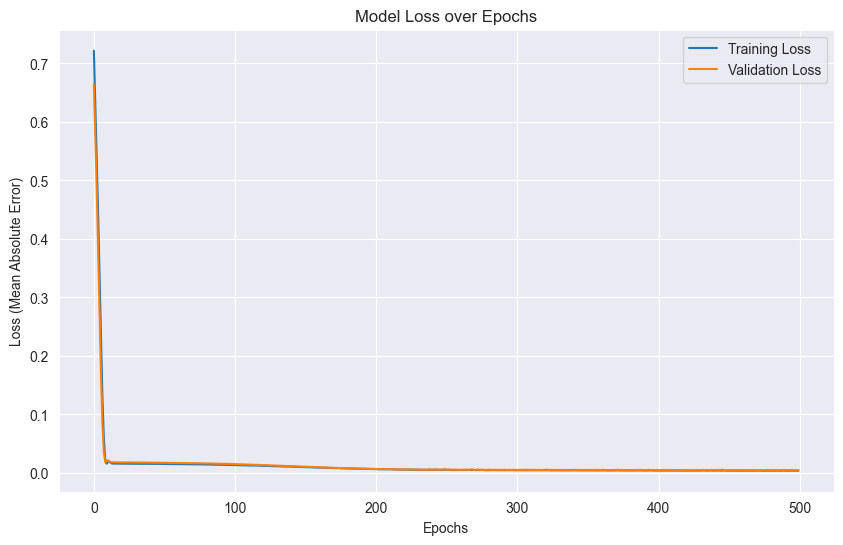

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(history_denoised.history['loss'], label='Training Loss')
plt.plot(history_denoised.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()